In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import json
import os 
import random
import numpy as np
import scipy.stats as stats
from skimage.segmentation import slic
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
imagenet_path = './imagenet_samples'
image_paths = [os.path.join(imagenet_path, image_path) for image_path in os.listdir(imagenet_path) if image_path.endswith(('jpeg', 'JPEG'))]

# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True).to(device)
model.eval()  # Set model to evaluation mode

# Define the image preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]   
    )
])

# Load the ImageNet class index mapping
with open("imagenet_class_index.json") as f:
    class_idx = json.load(f)
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
idx2synset = [class_idx[str(k)][0] for k in range(len(class_idx))]
id2label = {v[0]: v[1] for v in class_idx.values()}

# imagenet_path = './imagenet_samples'

# # List of image file paths
# image_paths = [os.path.join(imagenet_path, img_path) for img_path in os.listdir(imagenet_path) if img_path.endswith(('jpg', 'jpeg', 'png'))]


# for image_path in image_paths:
#     # Open and preprocess the image
#     print('img_path : ', image_path)
#     input_image = Image.open(image_path).convert('RGB')
#     input_batch = preprocess(input_image)
#     input_batch = input_batch.unsqueeze(0)  # Create a mini-batch as expected by the model

#     # Move the input and model to GPU if available
#     if torch.cuda.is_available():
#         input_batch = input_batch.to('cuda')
#         model.to('cuda')

#     # Perform inference
#     with torch.no_grad():
#         output = model(input_batch)

#     # Get the predicted class index
#     _, predict_index = torch.max(output, 1)
#     predict_index = predict_index.item()
#     predicted_synset = idx2synset[predict_index]
#     predicted_label = idx2label[predict_index]

#     print(f"Predicted label: {predicted_synset} ({predicted_label})")

c:\Users\wctsai\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\wctsai\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
def get_image_batch(image):
    tensor = preprocess(image)
    batch = tensor.unsqueeze(0).to(device)
    return batch

In [3]:
def LIME(image, target_class):
    kernel_size = 0.25
    K = 30
    def generate_mask_images(image):
        image = np.array(image)
        # segments = slic(image)
        segments = slic(image, n_segments=100)
        segments_num = len(np.unique(segments))
        
        mask_images = []
        binary_masks = []
        
        # iterate numbers
        for _ in range(2000):
            mask_image = image.copy()
            segments_mask = [random.choice([0, 1]) for _ in range(segments_num)]
            
            for segment_id in range(segments_num):
                if segments_mask[segment_id] == 0:
                    pixels_mask = (segments == segment_id)
                    mask_image[pixels_mask] = 127
                    # mask_image[pixels_mask] = 255
                    # mask_image[pixels_mask] = 0
            
            mask_images.append(mask_image)
            binary_masks.append(segments_mask)
            
        return np.array(mask_images), np.array(binary_masks), segments
    
    def get_predictions(mask_images, model):
        predictions = []
        for mask_image in mask_images:
            perturbed_PIL_image = Image.fromarray(mask_image.astype('uint8'))
            input_batch = get_image_batch(perturbed_PIL_image)
            
            with torch.no_grad():
                output = model(input_batch)
                prediction = torch.softmax(output, dim=1)
            predictions.append(prediction.cpu().numpy()[0])
            
        return np.array(predictions)

    def get_weights(binary_masks, kernel_size):
        distances = pairwise_distances(
            binary_masks,
            binary_masks[0].reshape(1, -1),
            metric='cosine'
        ).ravel()
        weights = np.exp(-(distances ** 2) / kernel_size ** 2)
        return weights

    mask_images, binary_masks, segments = generate_mask_images(image)
    predictions = get_predictions(mask_images, model)
    weights = get_weights(binary_masks, kernel_size)

    lasso = Lasso(alpha=0.0005)
    lasso.fit(binary_masks, predictions[ : , target_class], sample_weight=weights)

    coef = np.abs(lasso.coef_)
    k_features = np.argsort(coef)[-K : ]

    results = np.zeros(np.array(image).shape[ : 2])
    for segment_id in k_features:
        mask = (segments == segment_id)
        results[mask] = lasso.coef_[segment_id]
    
    return results

In [4]:
def smoothgrad(image, target_class):
    noise_num = 0.2
    sample_num = 1000
    input_batch = get_image_batch(image)

    total_gradients = torch.zeros_like(input_batch)
    for _ in range(sample_num):
        noise = torch.normal(0, noise_num, input_batch.shape).to(input_batch.device)
        noisy_image = input_batch.clone() + noise
        noisy_image_copy = noisy_image.clone().detach().requires_grad_(True)
        if noisy_image_copy.grad is not None:
            noisy_image_copy.grad.zero_()
        
        output = model(noisy_image_copy)
        score = output[0][target_class]
        
        model.zero_grad()
        score.backward()
        
        gradients = noisy_image_copy.grad.detach()
        
        total_gradients += gradients
        
    smooth_gradients = total_gradients / sample_num

    results = torch.sum(torch.abs(smooth_gradients), dim=1).squeeze()
    return results.cpu().numpy()

In [5]:
# for image_path in image_paths:
#     input_batch = get_image_batch(image_path)

#     with torch.no_grad():
#         output = model(input_batch)

#     _, predicted_idx = torch.max(output, 1)
#     predicted_idx = predicted_idx.item()
#     predicted_synset = idx2synset[predicted_idx]
#     predicted_label = idx2label[predicted_idx]

In [6]:
def visualize_results(image, explanation):
    plt.figure()
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(explanation)
    plt.title('Results')
    plt.colorbar()
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

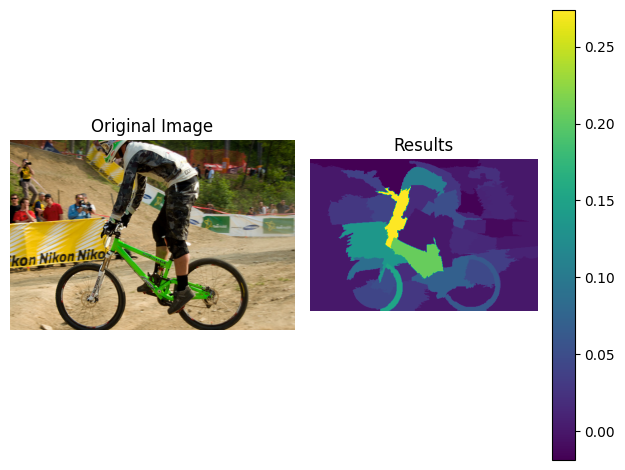

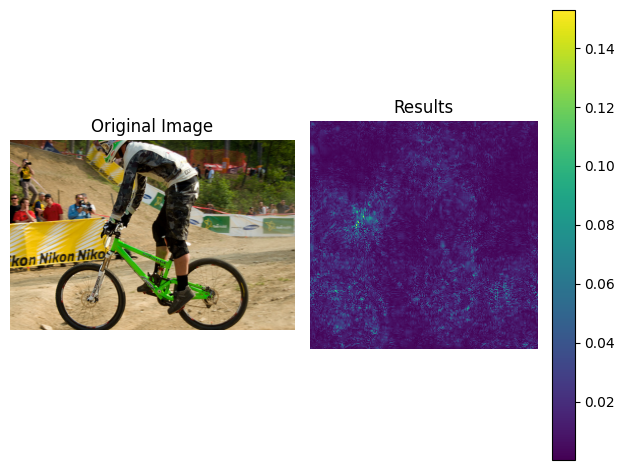

./imagenet_samples\mountain_bike.jpeg
mountain_bike

0.013046029788877648
0.018250544540992796


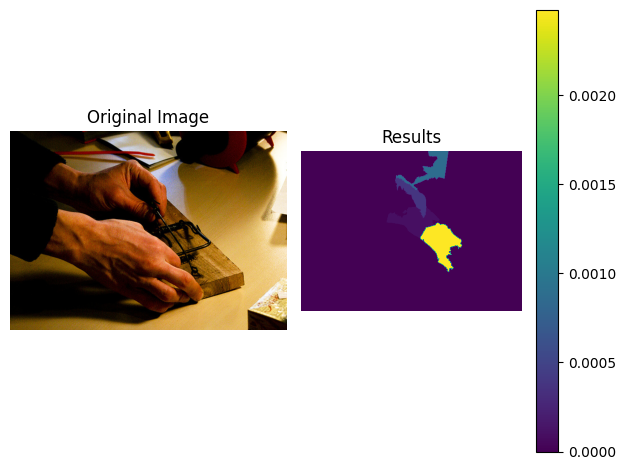

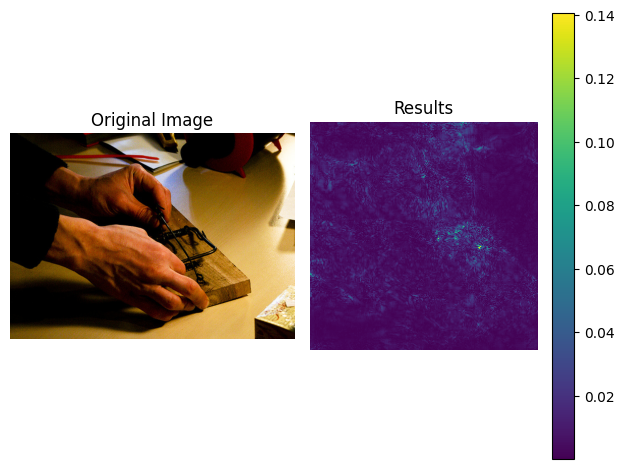

./imagenet_samples\mousetrap.jpeg
drumstick

-0.005090654254553033
-0.006317322956277258


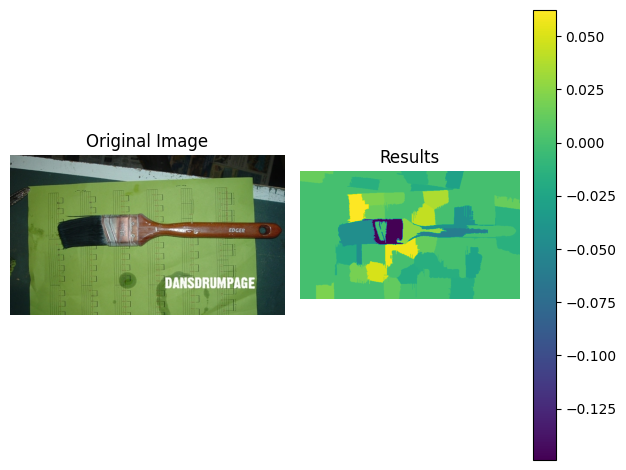

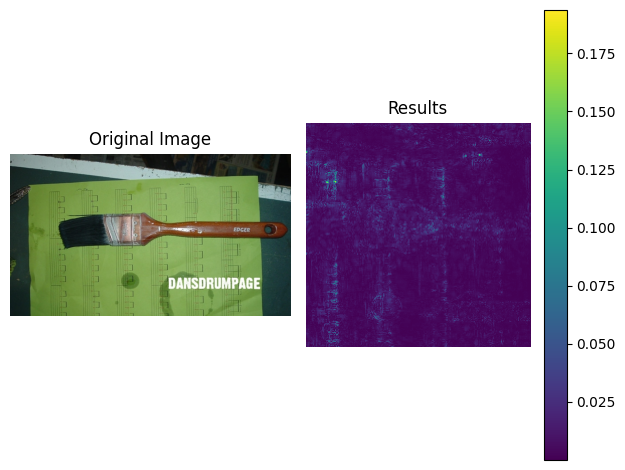

./imagenet_samples\paintbrush.jpeg
rule

-0.006608036965041986
-0.008938025654299625


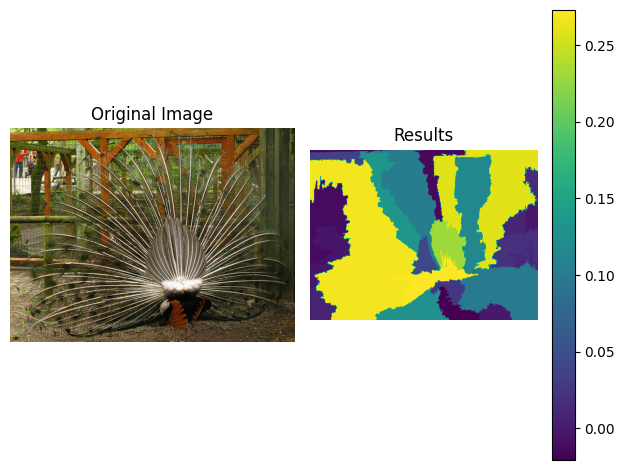

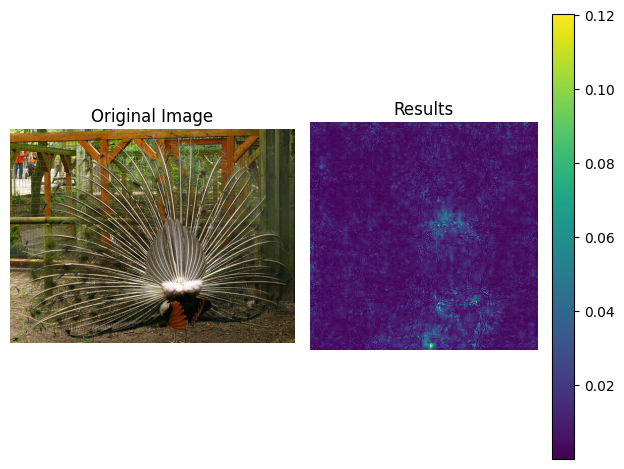

./imagenet_samples\peacock.jpeg
peacock

0.006076589399091334
0.008698339301231034


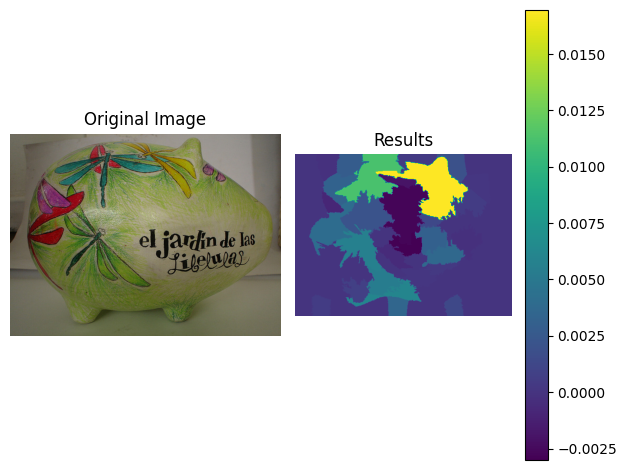

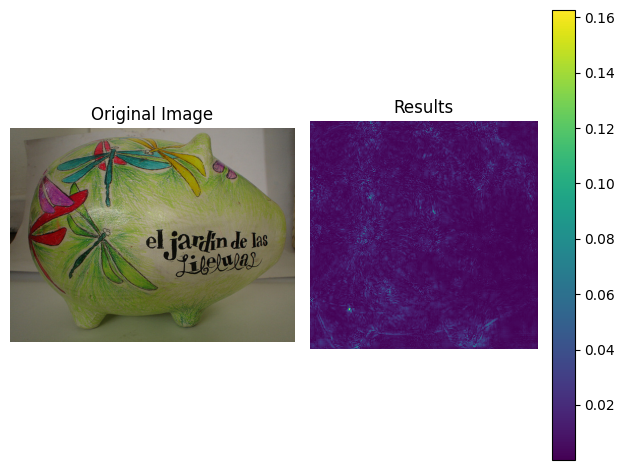

./imagenet_samples\piggy_bank.jpeg
pillow

-0.0008014370695106682
-0.0011047627757535257


In [7]:
for image_path in image_paths:
    image = Image.open(image_path).convert('RGB')
    input_batch = get_image_batch(image)

    with torch.no_grad():
        output = model(input_batch)
    _, predict_index = torch.max(output, 1)
    predict_index = predict_index.item()
    
    lime_results = LIME(image, predict_index)
    smoothgrad_results = smoothgrad(image, predict_index)
    
    visualize_results(image, lime_results)
    visualize_results(image, smoothgrad_results)

    print(image_path)
    print(idx2label[predict_index])
    print()

    smoothgrad_results = np.resize(smoothgrad_results, lime_results.shape)
    lime_normalize = (lime_results - lime_results.min()) / (lime_results.max() - lime_results.min())
    smoothgrad_normalize = (smoothgrad_results - smoothgrad_results.min()) / (smoothgrad_results.max() - smoothgrad_results.min())
    kendall_tau, _ = stats.kendalltau(lime_normalize.flatten(), smoothgrad_normalize.flatten())
    spearman, _ = stats.spearmanr(lime_normalize.flatten(), smoothgrad_normalize.flatten())
    print(kendall_tau)
    print(spearman)